# TP Stéréoscopie&Segmentation

## 1-Anaglyphe

In [1679]:
#imports
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank

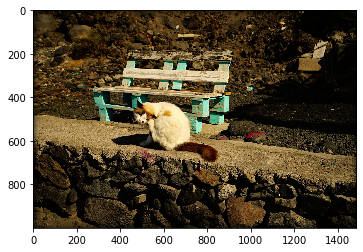

In [1680]:
cat_l = Image.open("cat_l.jpg")
plt.imshow(cat_l,'gray')
plt.show()

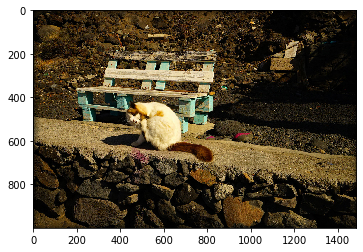

In [1681]:
cat_r = Image.open("cat_r.jpg")
plt.imshow(cat_r,'gray')
plt.show()

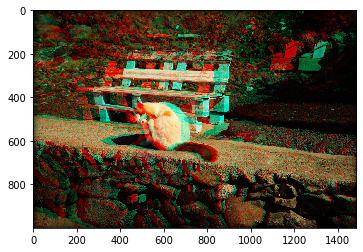

In [1682]:
cat_l_Red, cat_l_Green, cat_l_Blue = cat_l.split()
cat_r_Red, cat_r_Green, cat_r_Blue = cat_r.split()
anyglyhpe = Image.merge('RGB', [cat_r_Red, cat_l_Green, cat_l_Blue])
plt.imshow(anyglyhpe,'gray')
plt.show()

## 2- Carte de disparité

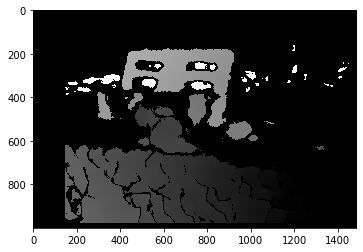

In [1683]:
cat_l = cv2.imread('cat_l.jpg',0)
cat_r = cv2.imread('cat_r.jpg',0)
## le meilleur compromis des parametres que j'ai pu trouver parmi la liste de tous le parametres
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=45)
disparity = stereo.compute(cat_l,cat_r)
plt.imshow(disparity,'gray')
plt.show()

#### Fermeture morphologique
##### 1-Faire disparaître les trous de petite taille dans les structures
##### 2-Connecter les structures proches

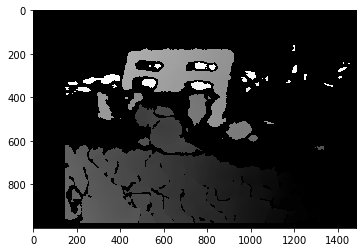

In [1684]:
kernel = np.ones((3,3), np.uint8)
closing = cv2.morphologyEx(disparity,cv2.MORPH_CLOSE,kernel, iterations = 2)
plt.imshow(closing,'gray') 
plt.show()


#### Ouverture morphologique
##### 1-Faire disparaître les trous de petite taille dans les structures
##### 2-Connecter les structures proches

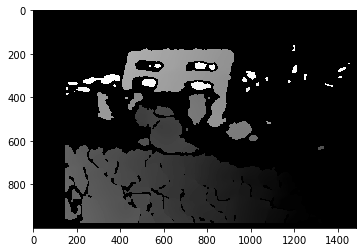

In [1685]:
opening = cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.imshow(opening,'gray') 
plt.show()

In [1686]:
cv2.imwrite('disparity.jpg',opening)

True

### 3-SEGEMENTATION

### WATERSHED SEGEMENTATION
#### 1 - Watershed segementation image originale

In [1687]:
img = cv2.imread('cat_l.jpg',1)

<function matplotlib.pyplot.show(*args, **kw)>

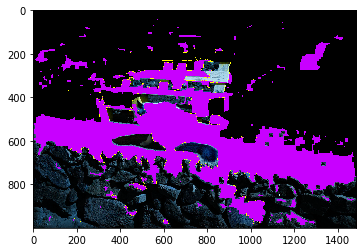

In [1688]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# debruité l'image
#utiliser des mask pour reperer les regions identiques
kernel = np.ones((10,10),np.uint8)
# lancer des ouvertures et fermetures morphologiques , des dilations et des erosions
# detecter l'arriere plan en faisant ça 
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
sure_bg = cv2.dilate(opening,kernel,iterations=1)
# trouver les objets en 1er plan dans l'image
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.007*dist_transform.max(),255,0)
# Trouver la region inconnu sur l'image
sure_fg = np.uint8(sure_fg)
unknown_region = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
# ajouter 1 pour tous les labels pour s'assurer que le backgroud sera pas à 0 mais à 1
markers = markers+1
# marquer la region inconnu avec 0
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,255,0]
#mettres des couleurs aux regions
img[markers == 1] = [200,0,255]
img[markers == 2] = [0,0,0]
img[markers == 3] = [0,0,0]
plt.imshow(img)
plt.show

#### 2 - Watershed segementation image de disparitée

In [1689]:
img = cv2.imread('disparity.jpg',1)


<function matplotlib.pyplot.show(*args, **kw)>

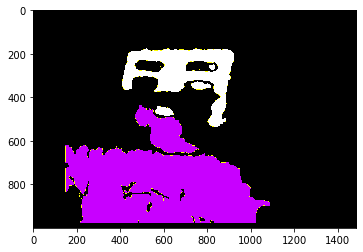

In [1690]:

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# debruité l'image
#utiliser des mask pour reperer les regions identiques
kernel = np.ones((13,13),np.uint8)
kernel1 = np.ones((12,12),np.uint8)

# lancer des ouvertures et fermetures morphologiques , des dilations et des erosions
# detecter l'arriere plan en faisant ça 
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel1, iterations = 1)
sure_erode = cv2.dilate(opening,kernel,iterations=5)
sure_bg = cv2.dilate(sure_erode,kernel1,iterations=4)
# trouver les objets en 1er plan dans l'image
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.007*dist_transform.max(),255,0)
# Trouver la region inconnu sur l'image
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
# ajouter 1 pour tous les labels pour s'assurer que le backgroud sera pas à 0 mais à 1
markers = markers+1
# marquer la region inconnu avec 0
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,255,0]
img[markers == 1] = [200,0,255]
img[markers == 2] = [0,0,0]
img[markers == 3] = [0,0,0]
img[markers == 4] = [0,0,0]
#cv2.imwrite('segmented.jpg',img)
plt.imshow(img)
plt.show


#### 3- Watershed segementation methode de gradient image originale 

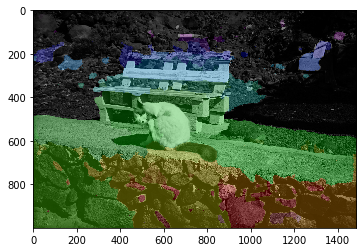

In [1691]:
image = cv2.imread('cat_l.jpg',0)
# debruité l'image 
denoised = rank.median(image, disk(15))
#Trouver les regions continues ou le gradient est <15
markers = rank.gradient(denoised, disk(6)) < 15
markers = ndi.label(markers)[0]
gradient = rank.gradient(denoised, disk(4))

# Lancer watershed sur gradient et masks
labels = watershed(gradient, markers)
plt.imshow(image, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.3)
plt.show()

#### 4- Watershed segementation methode de gradient image disparitée 

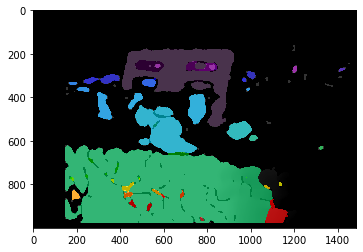

In [1692]:
image = cv2.imread('disparity.jpg',0)
# debruité l'image 
denoised = rank.median(image, disk(10))
#Trouver les regions continues ou le gradient est <10
markers = rank.gradient(denoised, disk(5)) < 15
markers = ndi.label(markers)[0]
# le gradient local
gradient = rank.gradient(denoised, disk(2))
# Lancer watershed sur gradient et masks
labels = watershed(gradient, markers)
plt.imshow(image, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.8)
plt.show()